## About this notebook

This notebook focus on: Gradient Accumulation with Tensorflow & TPU.

From [Distributions of no. of tokens](#Distributions-of-no.-of-tokens), we can see that there are non-negligible number of comments which have more than 256 tokens. It is probably worth training with a higher value for `MAX_LEN`. However, with a large model like `XLM Roberta Large`, we can't have the same batch size for `MAX_LEN = 512` as for `MAX_LEN = 192`. So I looked how [OpenNMT/OpenNMT-tf](https://github.com/OpenNMT/OpenNMT-tf/) implements gradient accumulation and copy the code with modification to this kernel.

The following picture shows the results of training on 65536 examples with different batch configurations (use the optimized training loop).

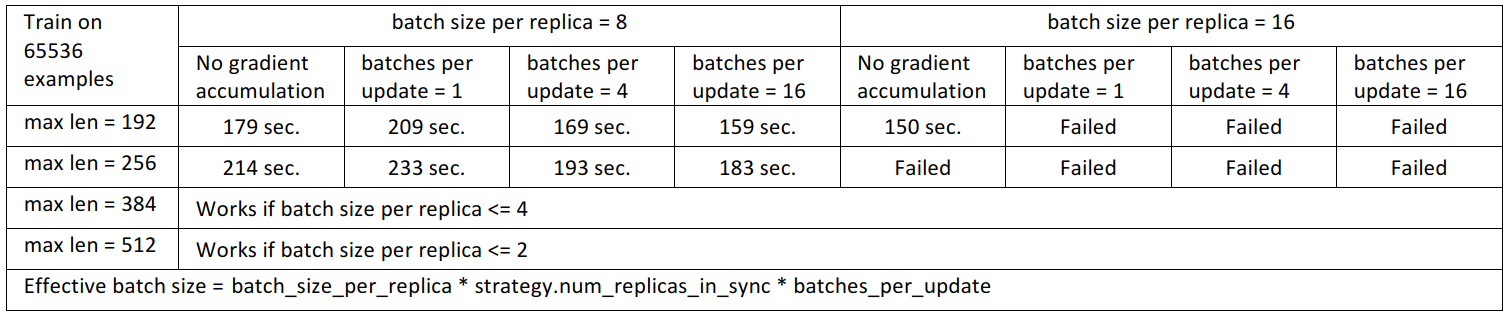

For `MAX_LEN = 192`, we can train with `batch_size_per_replica = 16` (without grandient accumulatioin). However, for `MAX_LEN = 256` or higher, `batch_size_per_replica = 16` no longer works. In order to keep the same effective batch size, it is necessary to use a smaller value for `batch_size_per_replica` with gradient accumulation.

The training configuation (fewer epochs / training examples, larger learning rate and `MAX_LEN = 192`) in this version is only for demonstrating the gradient accumulation works. Currently, my best LB score is given by:

    * MAX_LEN = 512
    * EPOCHS = 8
    * WARMUP_EPOCHS = 4
    * LEARNING_RATE_SCALING = 1
    * N_NEGATIVE_EXAMPLES_FACTOR = 2
    
However, it takes too long to train, and it can't be trained on Kaggle. I am still looking for a faster training configuation that can achieve the same result.

## Distributions of no. of tokens

We only look the comments with no. of tokens in the range (256, 512].

The tokens are obtained from the `bert-base-multilingual-cased` tokenizer. However, the distributions should be almost the same even other tokenizers are used.

| 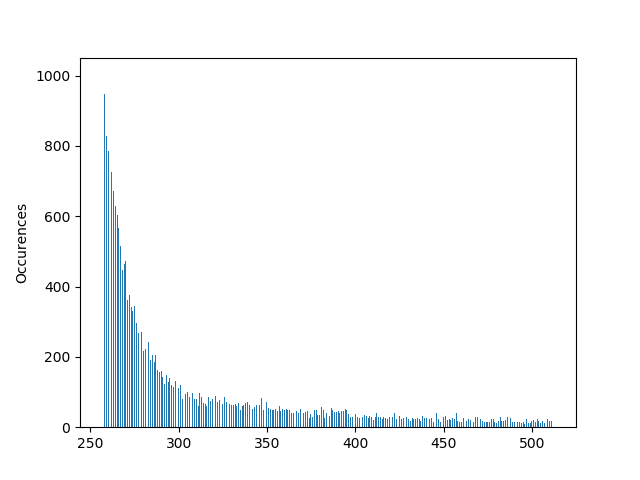 | 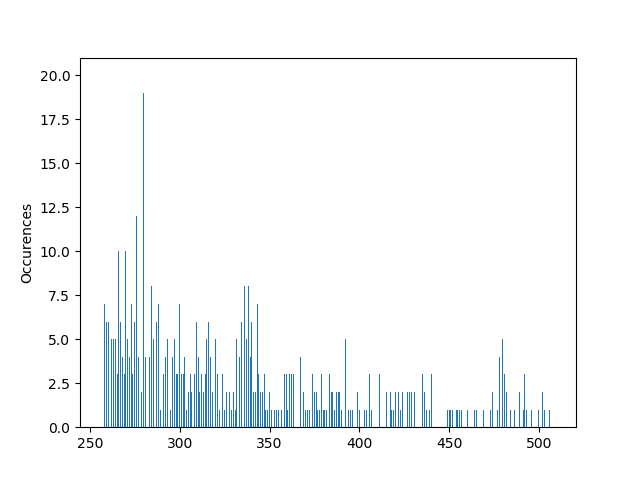 | 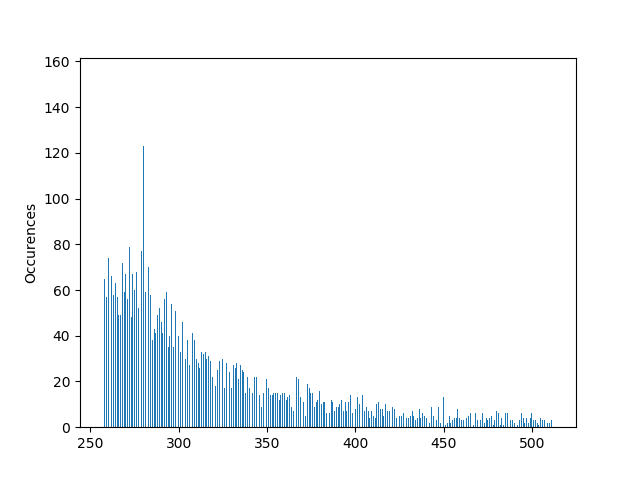 |
|:-|:-|:-|  
|training dataset|validation dataset|test dataset| 


In [ ]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm import tqdm
from tokenizers import BertWordPieceTokenizer
import datetime
from matplotlib import pyplot as plt
import sklearn

AUTO = tf.data.experimental.AUTOTUNE

print("Tensorflow version " + tf.__version__)

## Seed

In [ ]:
# Set `DETERMINISTIC` to `True`
# if you want to have more stable results among different trainings.
DETERMINISTIC = True

SEED = 0

GLOBAL_SEED = None
OP_SEED = None

if DETERMINISTIC:

    GLOBAL_SEED = SEED
    OP_SEED = SEED

    tf.random.set_seed(seed=GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

## TPU or GPU detection

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

## Configuration

In [ ]:
# Easier to do experiments.
CONFIG_DICT = {
    "distilbert-base-multilingual-cased": {
        'fast_encode': True,
        'fast_tokenizer_class': BertWordPieceTokenizer,
        'padding_token': 0
    },
    'bert-base-multilingual-cased': {
        'fast_encode': True,
        'fast_tokenizer_class': BertWordPieceTokenizer,
        'padding_token': 0
    },
    'jplu/tf-xlm-roberta-base': {
        'fast_encode': False,
        'padding_token': 1
    },
    'jplu/tf-xlm-roberta-large': {
        'fast_encode': False,
        'padding_token': 1
    }
}

# TRANSFORMER_TYPE = 'distilbert-base-multilingual-cased'
# TRANSFORMER_TYPE = 'bert-base-multilingual-cased'
# TRANSFORMER_TYPE = 'jplu/tf-xlm-roberta-base'
TRANSFORMER_TYPE = 'jplu/tf-xlm-roberta-large'

CONFIG = CONFIG_DICT[TRANSFORMER_TYPE]

FAST_ENCODE = CONFIG['fast_encode']
if FAST_ENCODE:
    FAST_TOKENIZER_CLASS = CONFIG['fast_tokenizer_class']
PADDING_TOKEN = CONFIG['padding_token']

MAX_LEN = 192  # 512

EPOCHS = 3  # 8
WARMUP_EPOCHS = 1  # 4

# The number of examples for which the training procedure running on a single replica will compute the gradients once in order to accumulate them.
BATCH_SIZE_PER_REPLICA = 8  # 2

# Accumulate `BATCHES_PER_UPDATE` of gradients before updating the model's parameters.
BATCHES_PER_UPDATE = 2  # 8

# The batch size for prediction procedure running on a single replica.
PREDICTION_BATCH_SIZE_PER_REPLICA = 32

LEARNING_RATE_SCALING = 2  # 1
START_LR = 5e-6
MAX_LR = 1e-5  # * strategy.num_replicas_in_sync
ENDING_LR = 5e-6

SHUFFLE_BUFFER_SIZE = 4096

# If to convert labels to 0 and 1.
ROUND_LABELS = True

# The number of positive examples to sample from each training .csv files.
# Set to `None` to use all positive examples.
N_POSITIVE_EXAMPLES_TO_SAMPLE = None

# The number of negative examples to sample from each training .csv files
# will be `N_NEGATIVE_EXAMPLES_FACTOR * N_POSITIVE_EXAMPLES_TO_SAMPLE`.
# Set to `None` to use all negative examples.
N_NEGATIVE_EXAMPLES_FACTOR = 1  # 2

# If to use optimized training / validation loops.
OPTIMIZED_LOOP = True

# If to use gradient accumulation.
USE_GRADIENT_ACCUMULATION = True
if BATCHES_PER_UPDATE > 1:
    USE_GRADIENT_ACCUMULATION = True

## Dataset methods

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)


def regular_encode(texts, tokenizer, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta
    """
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_attention_masks=False,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )

    return np.array(enc_di['input_ids'])


def get_training_dataset(batch_size):

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.repeat()

    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=OP_SEED)

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)

    return dataset


def get_validation_dataset(batch_size, repeated=False):

    dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

    if repeated:
        dataset = dataset.repeat()

        # If no repetition, don't shuffle validation dataset
        if not DETERMINISTIC:
            dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=OP_SEED)

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)

    return dataset


def get_test_dataset(batch_size):

    dataset = tf.data.Dataset.from_tensor_slices(x_test)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)

    return dataset

## Get datasets

In [ ]:
# From https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras

# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_TYPE)

# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

# Reload it with the huggingface tokenizers library
if FAST_ENCODE:
    fast_tokenizer = FAST_TOKENIZER_CLASS('vocab.txt', lowercase=False)

# CSV
train_1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train_2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

if ROUND_LABELS:
    train_2.toxic = train_2.toxic.round().astype(int)

POSITIVE_EXAMPLES_1 = train_1[['comment_text', 'toxic']].query('toxic > 0.5')
POSITIVE_EXAMPLES_2 = train_2[['comment_text', 'toxic']].query('toxic > 0.5')
NEGATIVE_EXAMPLES_1 = train_1[['comment_text', 'toxic']].query('toxic <= 0.5')
NEGATIVE_EXAMPLES_2 = train_2[['comment_text', 'toxic']].query('toxic <= 0.5')

POSITIVE_EXAMPLES_USED_1 = POSITIVE_EXAMPLES_1
POSITIVE_EXAMPLES_USED_2 = POSITIVE_EXAMPLES_2
NEGATIVE_EXAMPLES_USED_1 = NEGATIVE_EXAMPLES_1
NEGATIVE_EXAMPLES_USED_2 = NEGATIVE_EXAMPLES_2

if N_POSITIVE_EXAMPLES_TO_SAMPLE is not None:
    POSITIVE_EXAMPLES_USED_1 = POSITIVE_EXAMPLES_USED_1.sample(n=N_POSITIVE_EXAMPLES_TO_SAMPLE, random_state=OP_SEED)
    POSITIVE_EXAMPLES_USED_2 = POSITIVE_EXAMPLES_USED_2.sample(n=N_POSITIVE_EXAMPLES_TO_SAMPLE, random_state=OP_SEED)

if N_NEGATIVE_EXAMPLES_FACTOR is not None:
    NEGATIVE_EXAMPLES_USED_1 = NEGATIVE_EXAMPLES_1.sample(n=int(len(POSITIVE_EXAMPLES_USED_1) * N_NEGATIVE_EXAMPLES_FACTOR), random_state=OP_SEED)    
    NEGATIVE_EXAMPLES_USED_2 = NEGATIVE_EXAMPLES_2.sample(n=int(len(POSITIVE_EXAMPLES_USED_2) * N_NEGATIVE_EXAMPLES_FACTOR), random_state=OP_SEED)    

# Combine train_1 with a subset of train_2
train = pd.concat([
    POSITIVE_EXAMPLES_USED_1,
    NEGATIVE_EXAMPLES_USED_1,
    POSITIVE_EXAMPLES_USED_2,
    NEGATIVE_EXAMPLES_USED_2
])
# Shuffle
train = sklearn.utils.shuffle(train, random_state=OP_SEED)

valid = valid[['comment_text', 'toxic']]

N_TRAINING_EXAMPLES = len(train)
N_VALIDATION_EXAMPLES = len(valid)
N_TEST_EXAMPLES = len(test)

print(f'N_TRAINING_EXAMPLES = {N_TRAINING_EXAMPLES}')
print(f'N_POSITIVE_EXAMPLES = {len(POSITIVE_EXAMPLES_USED_1) + len(POSITIVE_EXAMPLES_USED_2)}')
print(f'N_NEGATIVE_EXAMPLES = {len(NEGATIVE_EXAMPLES_USED_1) + len(NEGATIVE_EXAMPLES_USED_2)}')
print(f'N_VALIDATION_EXAMPLES = {N_VALIDATION_EXAMPLES}')
print(f'N_TEST_EXAMPLES = {N_TEST_EXAMPLES}')

In [ ]:
if FAST_ENCODE:
    x_train = fast_encode(train.comment_text.values, fast_tokenizer, maxlen=MAX_LEN)
    x_valid = fast_encode(valid.comment_text.values, fast_tokenizer, maxlen=MAX_LEN)
    x_test = fast_encode(test.content.values, fast_tokenizer, maxlen=MAX_LEN)
else:
    x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
    x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
    x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

#  Labels needs to be reshaped
y_train = train['toxic'].values.reshape(len(x_train), 1)
y_valid = valid['toxic'].values.reshape(len(x_valid), 1)

## Peek the datasets

In [ ]:
training_dataset = get_training_dataset(batch_size=2)
validation_dataset = get_validation_dataset(batch_size=2)
test_dataset = get_test_dataset(batch_size=2)

for batch in training_dataset.take(1):
    print(batch)

for batch in validation_dataset.take(1):
    print(batch)

for batch in test_dataset.take(1):
    print(batch)

## Gradient Accumulator

Copy from the [OpenNMT/OpenNMT-tf](https://github.com/OpenNMT/OpenNMT-tf/) with modification.


In [ ]:
# https://github.com/OpenNMT/OpenNMT-tf/blob/f14c05a7cb8b1b8f3a692d6fea3c12067bc3eb2c/opennmt/optimizers/utils.py#L64

class GradientAccumulator(object):
    """Gradient accumulation utility.
    When used with a distribution strategy, the accumulator should be called in a
    replica context. Gradients will be accumulated locally on each replica and
    without synchronization. Users should then call ``.gradients``, scale the
    gradients if required, and pass the result to ``apply_gradients``.
    """

    # We use the ON_READ synchronization policy so that no synchronization is
    # performed on assignment. To get the value, we call .value() which returns the
    # value on the current replica without synchronization.

    def __init__(self):
        """Initializes the accumulator."""

        self._gradients = []

    def gradients(self):
        """The accumulated gradients on the current replica."""

        if not self._gradients:
            raise ValueError("The accumulator should be called first to initialize the gradients")

        # return list(gradient.value() for gradient in self._gradients)
        return self._gradients

    def __call__(self, gradients):
        """Accumulates :obj:`gradients` on the current replica."""

        if not self._gradients:

            self._gradients.extend(
                [
                    tf.Variable(
                        tf.zeros_like(gradient),
                        trainable=False,
                        synchronization=tf.VariableSynchronization.ON_READ
                    ) if gradient is not None else None for gradient in gradients
                ]
            )

        if len(gradients) != len(self._gradients):
            raise ValueError("Expected %s gradients, but got %d" % (
                    len(self._gradients), len(gradients)))

        for accum_gradient, gradient in zip(self._gradients, gradients):
            if gradient is not None:
                accum_gradient.assign_add(gradient)

    def reset(self):
        """Resets the accumulated gradients on the current replica."""

        if not self._gradients:
            return

        for gradient in self._gradients:
            if gradient is not None:
                gradient.assign(tf.zeros_like(gradient))

## batch configurations

In [ ]:
# The total number of examples for which the training procedure will compute the gradients once in order to accumulate them.
# This is also used for validation step.
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# The number of examples for which the training procedure will update the model's parameters once.
# This is the `effective` batch size, which will be used in tf.data.Dataset.
UPDATE_SIZE = BATCH_SIZE * BATCHES_PER_UPDATE

# The number of parameter updates in 1 epoch
UPDATES_PER_EPOCH = N_TRAINING_EXAMPLES // UPDATE_SIZE

PREDICTION_BATCH_SIZE = PREDICTION_BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# The number of batches for a validation step.
VALID_BATCHES_PER_EPOCH = N_VALIDATION_EXAMPLES // PREDICTION_BATCH_SIZE

## Model

In [ ]:
class Toxic_Classifier(tf.keras.models.Model):

    def __init__(self, transformer):

        super(Toxic_Classifier, self).__init__()

        self.transformer = transformer
        self.dropout = tf.keras.layers.Dropout(rate=0.25, name='dropout')
        self.average_pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name='average_pooling_layer')
        self.max_pooling_layer = tf.keras.layers.GlobalMaxPool1D(name='max_pooling_layer')
        self.dense_layer = tf.keras.layers.Dense(
            1, name='probabilities', activation='sigmoid',
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=OP_SEED),
            bias_initializer='zeros'
        )

    def call(self, inputs, **kwargs):

        comments = inputs
        attention_mask = tf.math.not_equal(comments, PADDING_TOKEN)

        # sequence_outpu: shape = [batch_size, seq_len, hidden_dim]
        # pooled_output: shape = [batch_size, hidden_dim]
        sequence_output = self.transformer([comments, attention_mask], **kwargs)[0]

        # shape = [batch_size, hidden_dim]
        average_pooling = self.average_pooling_layer(sequence_output, mask=attention_mask)
        
        # Avoid the padding timestamps to contribute to `max_pooling`
        sequence_output_masked = sequence_output * tf.cast(attention_mask, tf.float32)[:, :, tf.newaxis] - (1e9) * tf.cast(tf.math.logical_not(attention_mask), tf.float32)[:, :, tf.newaxis]
        max_pooling = self.max_pooling_layer(sequence_output_masked)

        pooling = tf.concat([average_pooling, max_pooling], axis=1)

        # shape = [batch_size, seq_len, hidden_dim]
        x = self.dropout(pooling, training=kwargs.get('training', False))

        # shape = [batch_size, 1]
        probabilities = self.dense_layer(x)

        return probabilities


class CustomExponentialDecaySchedule(tf.keras.optimizers.schedules.ExponentialDecay):
    """
    Learning rate with exponential decay and linear warmup.
    """

    def __init__(
            self,
            start_lr,
            max_lr,
            ending_lr,
            num_training_steps,
            num_warmup_steps,
            scaling=1,
            cycle=False,
            name=None,
      ):

        self.start_lr = tf.cast(start_lr, tf.float32)
        self.max_lr = tf.cast(max_lr, tf.float32)
        self.ending_lr = tf.cast(ending_lr, tf.float32)

        self.decay_rate = self.ending_lr / self.max_lr

        self.num_training_steps = tf.cast(num_training_steps, tf.float32)
        self.num_warmup_steps = max(num_warmup_steps, 0)

        self.decay_steps = self.num_training_steps - self.num_warmup_steps

        self.decay_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            self.max_lr,
            self.decay_steps,
            self.decay_rate,
            staircase=False,
            name=name
        )

        self.scaling = scaling

        self.cycle = tf.constant(cycle, dtype=tf.bool)

    def __call__(self, step):

        step = tf.cond(self.cycle and step >= self.num_training_steps, lambda: step % self.num_training_steps, lambda: tf.cast(step, tf.float32))
        lr = self.decay_lr_schedule(step)
        lr = tf.math.maximum(lr, self.ending_lr)

        if self.num_warmup_steps > 0:

            num_warmup_steps = tf.cast(self.num_warmup_steps, tf.float32)

            is_warmup = tf.cast(step < num_warmup_steps, tf.float32)

            warmup_lr = (self.max_lr - self.start_lr) / num_warmup_steps * step + self.start_lr

            decay_lr = self.decay_lr_schedule(step - num_warmup_steps)
            decay_lr = tf.math.maximum(decay_lr, self.ending_lr)

            lr = (1.0 - is_warmup) * decay_lr + is_warmup * warmup_lr

        return lr * self.scaling

In [ ]:
def set_model(learning_rate_scaling=1):

    with strategy.scope():

        transformer = TFAutoModel.from_pretrained(TRANSFORMER_TYPE)
        model = Toxic_Classifier(transformer)

        # number of training steps
        num_training_steps = UPDATES_PER_EPOCH * EPOCHS

        # warmup epochs
        num_warmup_steps = UPDATES_PER_EPOCH * WARMUP_EPOCHS

        lr_schedule = CustomExponentialDecaySchedule(
            start_lr=START_LR,
            max_lr=MAX_LR,
            ending_lr=ENDING_LR,
            num_training_steps=num_training_steps,
            num_warmup_steps=num_warmup_steps,
            scaling=learning_rate_scaling,
            cycle=False,
            name=None
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        gradient_accumulator = None
        if USE_GRADIENT_ACCUMULATION:
            gradient_accumulator = GradientAccumulator()
            gradient_accumulator.reset()

        # Instantiate metrics
        train_accuracy = tf.keras.metrics.BinaryAccuracy()
        valid_accuracy = tf.keras.metrics.BinaryAccuracy()
        train_loss = tf.keras.metrics.Sum()
        valid_loss = tf.keras.metrics.Sum()

        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM)

        return model, loss_fn, optimizer, gradient_accumulator, train_loss, train_accuracy, valid_loss, valid_accuracy

## Training routines

In [ ]:
def set_routines():

    with strategy.scope():

        def train_step_1_forward_backward(comments, labels):

            with tf.GradientTape() as tape:

                probabilities = model(comments, training=True)
                loss = loss_fn(labels, probabilities)

                # Take into account the fact that 1 parameter update for `UPDATE_SIZE` training examples.
                scaled_loss = loss / UPDATE_SIZE

            grads = tape.gradient(scaled_loss, model.trainable_variables)

            # Accumulated already scaled gradients
            if USE_GRADIENT_ACCUMULATION:
                gradient_accumulator(grads)

            # update metrics
            train_accuracy.update_state(labels, probabilities)
            train_loss.update_state(loss)

            if not USE_GRADIENT_ACCUMULATION:
                return grads

        def train_step_1_update(comments, labels):

            if not USE_GRADIENT_ACCUMULATION:

                grads = train_step_1_forward_backward(comments, labels)
                optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))

            else:

                for _ in tf.range(BATCHES_PER_UPDATE):

                    # Take the 1st `BATCH_SIZE_PER_REPLICA` examples.
                    small_comments = comments[:BATCH_SIZE_PER_REPLICA]
                    small_labels = labels[:BATCH_SIZE_PER_REPLICA]

                    train_step_1_forward_backward(small_comments, small_labels)

                    # Move the leading part to the end, so the shape is not changed.
                    comments = tf.concat([comments[BATCH_SIZE_PER_REPLICA:], small_comments], axis=0)
                    labels = tf.concat([labels[BATCH_SIZE_PER_REPLICA:], small_labels], axis=0)

                # Update the model's parameters
                gradients = gradient_accumulator.gradients()
                optimizer.apply_gradients(list(zip(gradients, model.trainable_variables)))
                gradient_accumulator.reset()

        @tf.function
        def dist_train_step(batch):
            strategy.experimental_run_v2(train_step_1_update, batch)

        @tf.function
        def dist_train_1_epoch(data_iter):

            for _ in tf.range(UPDATES_PER_EPOCH):
                dist_train_step(next(data_iter))

        def valid_step(comments, labels):

            probabilities = model(comments, training=False)
            loss = loss_fn(labels, probabilities)

            # update metrics
            valid_accuracy.update_state(labels, probabilities)
            valid_loss.update_state(loss)

        @tf.function
        def dist_valid_step(batch):
            strategy.experimental_run_v2(valid_step, batch)

        @tf.function
        def dist_valid(data_iter):

            for _ in tf.range(VALID_BATCHES_PER_EPOCH):
                dist_valid_step(next(data_iter))

        return dist_train_1_epoch, dist_train_step, dist_valid, dist_valid_step

## Datasets

In [ ]:
print("NUM_TRAINING_EXAMPLES: {}".format(N_TRAINING_EXAMPLES))
print("BATCH_SIZE_PER_REPLICA: {}".format(BATCH_SIZE_PER_REPLICA))
print("BATCH_SIZE: {}".format(BATCH_SIZE))
print("BATCHES_PER_UPDATE: {}".format(BATCHES_PER_UPDATE))
print("UPDATE_SIZE: {}".format(UPDATE_SIZE))
print("UPDATES_PER_EPOCH: {}".format(UPDATES_PER_EPOCH))
print("NUM_VALIDATION_EXAMPLES: {}".format(N_VALIDATION_EXAMPLES))
print("PREDICTION_BATCH_SIZE: {}".format(PREDICTION_BATCH_SIZE))
print("VALID_BATCHES_PER_EPOCH: {}".format(VALID_BATCHES_PER_EPOCH))

train_ds = get_training_dataset(batch_size=UPDATE_SIZE)
train_dist_ds = strategy.experimental_distribute_dataset(train_ds)

valid_ds = get_validation_dataset(batch_size=PREDICTION_BATCH_SIZE, repeated=True)
valid_dist_ds = strategy.experimental_distribute_dataset(valid_ds)

## Usual custom training loop
Slower, but training information could be shown more often.

In [ ]:
if not OPTIMIZED_LOOP:

    with strategy.scope():
    
        model, loss_fn, optimizer, gradient_accumulator, train_loss, train_accuracy, valid_loss, valid_accuracy = set_model(learning_rate_scaling=LEARNING_RATE_SCALING)
        dist_train_1_epoch, dist_train_step, dist_valid, dist_valid_step = set_routines()

        for epoch_idx in range(EPOCHS):

            s = datetime.datetime.now()

            for batch_idx, batch in enumerate(train_dist_ds):

                if batch_idx >= UPDATES_PER_EPOCH:
                    break

                dist_train_step(batch)

                loss = train_loss.result() / ((batch_idx + 1) * UPDATE_SIZE)
                acc = train_accuracy.result()

                if (batch_idx + 1) == UPDATES_PER_EPOCH or (batch_idx + 1) % (UPDATES_PER_EPOCH // 10) == 0:
                    print("epoch: {} | batch: {}".format(epoch_idx + 1, batch_idx + 1))
                    print("train loss: {}".format(loss))
                    print("train accuracy: {}".format(acc))

            train_loss.reset_states()
            train_accuracy.reset_states()

            e = datetime.datetime.now()
            print("training time: {}".format((e-s).total_seconds()))

            s = datetime.datetime.now()

            for batch_idx, batch in enumerate(valid_dist_ds):

                if batch_idx >= VALID_BATCHES_PER_EPOCH:
                    break

                dist_valid_step(batch)

                val_loss = valid_loss.result() / (VALID_BATCHES_PER_EPOCH * PREDICTION_BATCH_SIZE)
                val_acc = valid_accuracy.result()

            print("valid loss: {}".format(val_loss))
            print("valid accuracy: {}".format(val_acc))

            valid_loss.reset_states()
            valid_accuracy.reset_states()

            e = datetime.datetime.now()
            print("validation time: {}".format((e-s).total_seconds()))

            print("-" * 80)

## Optimized custom training loop

Optimized by calling the TPU less often and performing more steps per call.
Training information is shown after each epoch.


In [ ]:
if OPTIMIZED_LOOP:

    with strategy.scope():

        model, loss_fn, optimizer, gradient_accumulator, train_loss, train_accuracy, valid_loss, valid_accuracy = set_model(learning_rate_scaling=LEARNING_RATE_SCALING)
        dist_train_1_epoch, dist_train_step, dist_valid, dist_valid_step = set_routines()

        train_data_iter = iter(train_dist_ds)
        valid_data_iter = iter(valid_dist_ds)

        for epoch_idx in range(EPOCHS):

            s = datetime.datetime.now()

            dist_train_1_epoch(train_data_iter)

            loss = train_loss.result() / (UPDATES_PER_EPOCH * UPDATE_SIZE)
            acc = train_accuracy.result()

            print("epoch: {}".format(epoch_idx + 1))
            print("train loss: {}".format(loss))
            print("train accuracy: {}".format(acc))

            train_loss.reset_states()
            train_accuracy.reset_states()

            e = datetime.datetime.now()
            print("training time: {}".format((e-s).total_seconds()))

            s = datetime.datetime.now()

            dist_valid(valid_data_iter)

            val_loss = valid_loss.result() / (VALID_BATCHES_PER_EPOCH * PREDICTION_BATCH_SIZE)
            val_acc = valid_accuracy.result()

            print("valid loss: {}".format(val_loss))
            print("valid accuracy: {}".format(val_acc))

            valid_loss.reset_states()
            valid_accuracy.reset_states()

            e = datetime.datetime.now()
            print("validation time: {}".format((e-s).total_seconds()))

            print("-" * 80)

## Predict and submit

In [ ]:
with strategy.scope():

    def predict_step(comments):

        probabilities = model(comments, training=False)

        return probabilities

    @tf.function
    def dist_predict_step(batch):

        probabilities = strategy.experimental_run_v2(predict_step, args=[batch])

        return probabilities

test_ds = get_test_dataset(batch_size=PREDICTION_BATCH_SIZE)
dist_test_ds = strategy.experimental_distribute_dataset(test_ds)
print("PREDICTION_BATCH_SIZE: {}".format(PREDICTION_BATCH_SIZE))
PREDICTION_BATCHES = N_TEST_EXAMPLES // PREDICTION_BATCH_SIZE + int(N_TEST_EXAMPLES % PREDICTION_BATCH_SIZE > 0)
print("PREDICTION_BATCHES: {}".format(PREDICTION_BATCHES))

all_probabilities = []
for batch in tqdm(dist_test_ds):

    # PerReplica object
    probabilities = dist_predict_step(batch)

    # Tuple of tensors
    probabilities = strategy.experimental_local_results(probabilities)

    # tf.Tensor
    probabilities = tf.concat(probabilities, axis=0)

    all_probabilities.append(probabilities)

# tf.Tensor
predictions = tf.concat(all_probabilities, axis=0)
# numpy
predictions = predictions.numpy()

submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = predictions
submission.to_csv('submission.csv', index=False)
submission.head(10)

## Save model weights

In [ ]:
model.save_weights("model.h5")